# LCPB 20-21 Exercise 2: DNN
## RandomGroup
### Alessandro Casalino 2015122
### Michele M. Crudele 2021858
### Sabrina Giorgetti 2013375
### Daniele Mellino 2013373

## Overview

In this exercise we analyse data in the file “DATA/sequences16.dat”, that is composed of DNA-like sequences of 16 letters (A, C, T, G), each one associated to a label (0 or 1), according to a rule that we do not know. There are “only” 3000 samples in this dataset, while the dataset created during the lecture is made of 10000 samples, but the sequences are shorter (12 letters).

In the [first section](#1), we use the same DNN modelled during the lecture to fit the new data finding out that it is not converging, in contrast with what it does with the 10000 samples dataset.

As a consequence of that, in the [second section](#2) we try to make the model converge by “augmenting” the training data: for every sequence of length $L_s$ there are $L_s-1$ periodic shift, that is to say that we can create $L_s-1$ new samples from each of the 3000 samples in the dataset. On the other hand, this manipulation will associate the wrong label to some of the new sequences, as it can break the keys. In order to see which of the two effects is prevalent in terms of convergence of the model, we fit the same model to the new augmented data: what we discover is that now the model converges.

In the [third section](#3) we then implement a Grid Search to find the best possible combination of parameters to be used for modelling the DNN: we tried different activation units, different minimisation algorithms and also different dropouts. By means of this procedure, we find the best parameters, but we also noticed that the results are not so dependent on them (at least on the ones we have considered): if we do not use the SGD as minimization algorithm, the results are always quite satisfying and similar, since the differences are of order 10e-2).

We then try to improve the results by [rescaling the data](#4), using [-0.5, 0.5] instead of [0,1] for every bit of x[n], but also in this case the results are not significantly different from the previous ones: the only difference is that now the the minimization is more stable, as the loss curve oscillates less than before. This is done in section 4.

Finally, we also try to [modify the architecture of the model](#change_variables), performing a grid search on the number of nodes it is composed of: 32 is the best possible value between the ones considered.

To resume, a significant improvement of the performances of the DNN model we have considered has been achieved by the augmentation of the training data; as far as the minimization methods and the DNN characteristics, we can say that they are all working well (except the SGD) especially if we consider the error associated to the accuracy of the various combination of parameters and methods.

In [57]:
from IPython.display import HTML, display

display(HTML("<table><tr><td><img src='model_initial_dataset.png'></td><td><img src='model_moredata.png'></td></tr></table>"))
display(HTML("<table><tr><td><img src='model_bestparams.png'></td><td><img src='model_scaleddata.png'></td></tr></table>"))
display(HTML("<table><tr><td><img src='model_neur.png'></td></tr></table>"))

,


,


""


### Packages
We import the libraries and set the seeds for Numpy and Tensorflow.

In [27]:
import os.path
import time
import math
import pickle
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.optimizers import SGD

In [28]:
seed = 123

if tf.__version__ == "1.14.0":
    tf.set_random_seed(seed)
else:
    tf.random.set_seed(seed)

# <a name="1">  1.  Small database of samples with longer sequences  </a>

### Load and process the data
Here, we charge the data and we set the training and test percentage.

In [29]:
fname = 'sequences16.csv'
sx, sy = np.loadtxt(fname, delimiter=',', usecols=(0,1), unpack=True, dtype=str)

N = len(sy)
print(N)
Ls = len(sx[0])
print(Ls)
print(sx[0], sy[0])

perc_train = 0.8
N_train = int(N*perc_train)
N_test = N - N_train
print(f'\ndata: {N}\ntrain: {N_train}\ntest: {N_test}')

3000
16
AAGGTCTGCCGGCCGA 1

data: 3000
train: 2400
test: 600


We use the one hot encoding procedure.

In [30]:
Q = ['A', 'C', 'G', 'T']
Nc = 4
onehc = {Q[i]: i for i in range(Nc)}
print(onehc)

{'A': 0, 'C': 1, 'G': 2, 'T': 3}


In [31]:
y = sy.astype(int)

L = Ls * Nc
print(L)

x = np.zeros((N, L))
print(x[0])

for n in range(N):
    for i in range(Ls):
        x[n][i * 4 + onehc[sx[n][i]]] = 1
        
print(sx[0])
print(x[0])

64
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
AAGGTCTGCCGGCCGA
[1. 0. 0. 0. 1. 0. 0. 0. 0. 0. 1. 0. 0. 0. 1. 0. 0. 0. 0. 1. 0. 1. 0. 0.
 0. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 0. 1. 0. 0. 0. 0. 1. 0. 0. 0. 1. 0.
 0. 1. 0. 0. 0. 1. 0. 0. 0. 0. 1. 0. 1. 0. 0. 0.]


Then we split the data in train / test-validation.

In [32]:
(x_train, y_train) = (x[:N_train], y[:N_train])
(x_test, y_test) = (x[N_train:], y[N_train:])

print(y_train.sum() / N_train)
print(y_test.sum() / N_test)

0.24333333333333335
0.25833333333333336


### Definition of NN model using Keras
We define a NN with two hidden layers. We choose relu activation function for the input and hidden layers and the sigmoid activation function for the last one. We also add dropout in the second hidden layer.  

In [33]:
model = Sequential()

model.add(Dense(L, input_shape=(L,), activation='relu'))
model.add(Dense(L//2, activation='relu'))
model.add(Dense(L//4, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(1, activation='sigmoid'))

print(model.summary())

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_12 (Dense)             (None, 64)                4160      
_________________________________________________________________
dense_13 (Dense)             (None, 32)                2080      
_________________________________________________________________
dense_14 (Dense)             (None, 16)                528       
_________________________________________________________________
dropout_3 (Dropout)          (None, 16)                0         
_________________________________________________________________
dense_15 (Dense)             (None, 1)                 17        
Total params: 6,785
Trainable params: 6,785
Non-trainable params: 0
_________________________________________________________________
None


### Optimization and fit
We compile the NN using as loss the binary cross entropy and as optimizer the adam algorithm. Then we fit the model with a batch size equal to 50 for 30 epochs. We enable the shuffling of the batch-sized chunks.

In [34]:
model.compile(loss='binary_crossentropy', 
              optimizer="adam", 
              metrics=['accuracy'])

In [35]:
fit = model.fit(x_train, y_train, 
               epochs=30, batch_size = 50, 
               validation_data=(x_test, y_test),
               shuffle=True)

Epoch 1/30
48/48 [==============================] - 1s 9ms/step - loss: 0.5879 - accuracy: 0.7466 - val_loss: 0.5521 - val_accuracy: 0.7417
Epoch 2/30
48/48 [==============================] - 0s 3ms/step - loss: 0.5057 - accuracy: 0.7660 - val_loss: 0.5242 - val_accuracy: 0.7417
Epoch 3/30
48/48 [==============================] - 0s 3ms/step - loss: 0.5056 - accuracy: 0.7500 - val_loss: 0.5003 - val_accuracy: 0.7617
Epoch 4/30
48/48 [==============================] - 0s 3ms/step - loss: 0.4627 - accuracy: 0.7856 - val_loss: 0.4930 - val_accuracy: 0.7600
Epoch 5/30
48/48 [==============================] - 0s 4ms/step - loss: 0.4447 - accuracy: 0.7893 - val_loss: 0.4838 - val_accuracy: 0.7633
Epoch 6/30
48/48 [==============================] - 0s 3ms/step - loss: 0.4278 - accuracy: 0.8158 - val_loss: 0.4736 - val_accuracy: 0.7617
Epoch 7/30
48/48 [==============================] - 0s 4ms/step - loss: 0.4114 - accuracy: 0.8261 - val_loss: 0.4865 - val_accuracy: 0.7683
Epoch 8/30
48/48 [==

### Print the results
As we can see in the plots below, the model does not converge (the validation loss increase in time)  since we have a small training set.

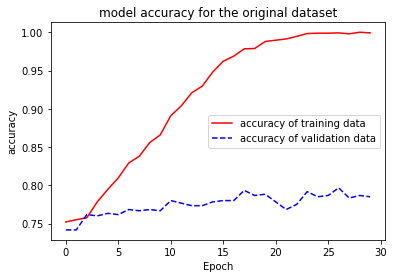

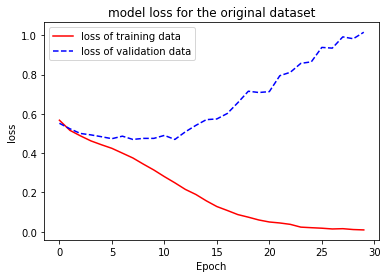

In [36]:
for obs in ('accuracy', 'loss'):
    plt.figure(figsize=(6,4))
    plt.plot(fit.history[obs],'r', label=obs+ ' of training data')
    #dashed line!!!
    plt.plot(fit.history['val_'+obs], 'b--', label=obs+' of validation data')
    plt.ylabel(obs)
    plt.xlabel('Epoch')
    plt.title('model ' + obs + " for the original dataset")
    plt.legend()
    plt.savefig('model_initial_dataset.png')
    plt.show()

#  <a name="2">  2. Data augmentation </a>

We augment the training data leaving unvariated the test data.

In [37]:
def rotate(l, n):
    return l[n:] + l[:n]

# print(sx[0],rotate(sx[0],-1))
new_sx = np.zeros(16*(N_train)).astype(str)
new_sy = np.zeros(16*(N_train))

for j in range(N_train):
    new_sy[16*j:16*(j+1)]=sy[j] #associa label
    for i in range(16):
        new_sx[16*j+i]=rotate(sx[j],-i)

In [38]:
N_train = len(new_sx)
N = N_train + N_test
print(N)
Ls = len(new_sx[0])
print(Ls)
# print(new_sx[38400-16], new_sy[38400-16])

print(f'\ndata: {N}\ntrain: {N_train}\ntest: {N_test}')

39000
16

data: 39000
train: 38400
test: 600


We repeat the same procedure as in the first section.

In [39]:
Q = ['A', 'C', 'G', 'T']
Nc = 4
onehc = {Q[i]: i for i in range(Nc)}
# print(onehc)

L = Ls * Nc
# print(L)

x_train = np.zeros((N_train,L))
# print(x_train[0])

for n in range(N_train):
    for i in range(Ls):
        x_train[n][i*4+onehc[new_sx[n][i]]] = 1
        
# print(new_sx[1])
# print(x_train[1])

y_train = new_sy

# print(y_train.sum() / N_train) # we control that test and train are similiar
# print(y_test.sum() / N_test)

In [40]:
model=Sequential()
model.add(Dense(L,input_shape=(L,),activation="relu")) #add 1 layer
model.add(Dense(L//2,activation="relu")) #add 1 layer
model.add(Dense(L//4,activation="relu")) #add 1 layer
model.add(Dropout(0.2)) #like this it should be set only on the last layer
model.add(Dense(1,activation="sigmoid"))

print(model.summary())#printout a summary with all the number of parameter ecc

model.compile(loss="binary_crossentropy",
             optimizer="adam",
             metrics=['accuracy']) #we use binary cross entropy,adam, and accuracy

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_16 (Dense)             (None, 64)                4160      
_________________________________________________________________
dense_17 (Dense)             (None, 32)                2080      
_________________________________________________________________
dense_18 (Dense)             (None, 16)                528       
_________________________________________________________________
dropout_4 (Dropout)          (None, 16)                0         
_________________________________________________________________
dense_19 (Dense)             (None, 1)                 17        
Total params: 6,785
Trainable params: 6,785
Non-trainable params: 0
_________________________________________________________________
None


In [41]:
fit = model.fit(x_train, y_train, 
               epochs=30, batch_size = 50, 
               validation_data=(x_test, y_test),
               shuffle=True)

Epoch 1/30
768/768 [==============================] - 2s 2ms/step - loss: 0.5282 - accuracy: 0.7527 - val_loss: 0.4668 - val_accuracy: 0.7833
Epoch 2/30
768/768 [==============================] - 2s 2ms/step - loss: 0.4365 - accuracy: 0.8017 - val_loss: 0.3965 - val_accuracy: 0.8150
Epoch 3/30
768/768 [==============================] - 1s 2ms/step - loss: 0.3502 - accuracy: 0.8482 - val_loss: 0.3275 - val_accuracy: 0.8567
Epoch 4/30
768/768 [==============================] - 1s 1ms/step - loss: 0.3024 - accuracy: 0.8759 - val_loss: 0.3071 - val_accuracy: 0.8683
Epoch 5/30
768/768 [==============================] - 1s 2ms/step - loss: 0.2792 - accuracy: 0.8866 - val_loss: 0.2929 - val_accuracy: 0.8783
Epoch 6/30
768/768 [==============================] - 1s 2ms/step - loss: 0.2619 - accuracy: 0.8982 - val_loss: 0.2779 - val_accuracy: 0.9000
Epoch 7/30
768/768 [==============================] - 1s 2ms/step - loss: 0.2492 - accuracy: 0.9084 - val_loss: 0.2764 - val_accuracy: 0.8917
Epoch 

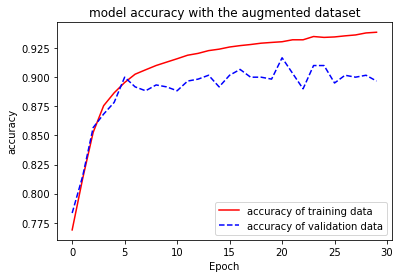

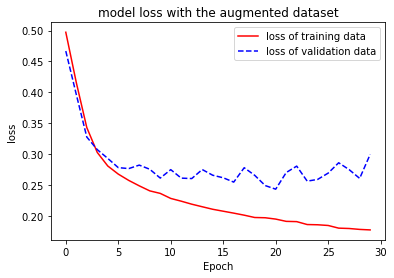

In [42]:
for obs in ('accuracy', 'loss'):
    plt.figure(figsize=(6,4))
    plt.plot(fit.history[obs],'r', label=obs+ ' of training data')
    #dashed line!!!
    plt.plot(fit.history['val_'+obs], 'b--', label=obs+' of validation data')
    plt.ylabel(obs)
    plt.xlabel('Epoch')
    plt.title('model ' + obs + ' with the augmented dataset')
    plt.legend()
    plt.savefig('model_moredata.png')
    plt.show()

In the plot above we see that the situation improves by augmenting the training data, the validation loss significantly decrease.

# <a name="3"> 3. Grid Search </a>
In this section we use grid search function in order to get the best combination of activation, optimization algorithm and dropout value. We adopt the cross validation method with 4 folds.
Since it is a long computation we save the result in a pickle file.

In [43]:
def compile_model(optimizer, activation, dropout_rate):
    # create the mode
    model=create_DNN(activation=activation, dropout_rate=dropout_rate)
    # compile the model
    model.compile(loss="binary_crossentropy",
                  optimizer=optimizer,
                  metrics=['accuracy'])
    return model

In [44]:
def create_DNN(activation, dropout_rate):
    
    model=Sequential()
    model.add(Dense(L,input_shape=(L,), activation=activation)) #add 1 layer
    model.add(Dense(L//2, activation=activation)) #add 1 layer
    model.add(Dense(L//4, activation=activation)) #add 1 layer
    model.add(Dropout(dropout_rate)) #like this it should be set only on the last layer
    model.add(Dense(1, activation="sigmoid"))
    
    return model

In [45]:
from sklearn.model_selection import GridSearchCV
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier

# call Keras scikit wrapper
model_gridsearch = KerasClassifier(build_fn=compile_model, 
                        epochs=50, 
                        batch_size=50, 
                        verbose=1)

# list of allowed optional arguments for the optimizer, see compile_model()
optimizer = ['SGD', 'RMSprop', 'Adam', 'Adamax']
activation = ['sigmoid', 'relu', 'elu']
dropout_rate = [0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]
# define parameter dictionary
param_grid = dict(optimizer=optimizer, activation=activation, dropout_rate=dropout_rate)

# call scikit grid search module
grid = GridSearchCV(estimator=model_gridsearch, param_grid=param_grid, n_jobs=-1, cv=4)

# Loads grid_result from file if it exists
if os.path.isfile("HEAVY_grid_result.pkl"):
    with open("HEAVY_grid_result.pkl", "rb") as fid:
        grid_result = pickle.load(fid)
else:
    grid_result = grid.fit(x_train,y_train)
    with open("HEAVY_grid_result.pkl", "wb") as fid:
        pickle.dump(grid_result, fid)

# summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

Best: 0.897812 using {'activation': 'sigmoid', 'dropout_rate': 0.2, 'optimizer': 'Adam'}
0.756667 (0.010992) with: {'activation': 'sigmoid', 'dropout_rate': 0.0, 'optimizer': 'SGD'}
0.876094 (0.005084) with: {'activation': 'sigmoid', 'dropout_rate': 0.0, 'optimizer': 'RMSprop'}
0.894010 (0.007809) with: {'activation': 'sigmoid', 'dropout_rate': 0.0, 'optimizer': 'Adam'}
0.893932 (0.007944) with: {'activation': 'sigmoid', 'dropout_rate': 0.0, 'optimizer': 'Adamax'}
0.756667 (0.010992) with: {'activation': 'sigmoid', 'dropout_rate': 0.1, 'optimizer': 'SGD'}
0.890260 (0.011459) with: {'activation': 'sigmoid', 'dropout_rate': 0.1, 'optimizer': 'RMSprop'}
0.894740 (0.008001) with: {'activation': 'sigmoid', 'dropout_rate': 0.1, 'optimizer': 'Adam'}
0.888438 (0.008139) with: {'activation': 'sigmoid', 'dropout_rate': 0.1, 'optimizer': 'Adamax'}
0.756667 (0.010992) with: {'activation': 'sigmoid', 'dropout_rate': 0.2, 'optimizer': 'SGD'}
0.878568 (0.024521) with: {'activation': 'sigmoid', 'dropo

In [46]:
best_activation = "sigmoid"
best_dropout = 0.2
best_optimizer = "Adam"

Once we get the best parameters, we refit the model, and we show the results.
We find out that the best combination is given by the use of the sigmoid activation function with Adam and dropout rate equal to 0.2

In [47]:
model=compile_model(optimizer=best_optimizer, activation=best_activation, dropout_rate=best_dropout)
fit = model.fit(x_train, y_train, 
               epochs=50, batch_size = 50, 
               validation_data=(x_test, y_test),
               shuffle=True)

Epoch 1/50
768/768 [==============================] - 2s 2ms/step - loss: 0.5633 - accuracy: 0.7479 - val_loss: 0.4997 - val_accuracy: 0.7533
Epoch 2/50
768/768 [==============================] - 2s 2ms/step - loss: 0.4979 - accuracy: 0.7675 - val_loss: 0.4984 - val_accuracy: 0.7617
Epoch 3/50
768/768 [==============================] - 2s 3ms/step - loss: 0.5015 - accuracy: 0.7696 - val_loss: 0.4969 - val_accuracy: 0.7650
Epoch 4/50
768/768 [==============================] - 1s 1ms/step - loss: 0.4954 - accuracy: 0.7720 - val_loss: 0.4946 - val_accuracy: 0.7650
Epoch 5/50
768/768 [==============================] - 1s 1ms/step - loss: 0.4928 - accuracy: 0.7732 - val_loss: 0.4934 - val_accuracy: 0.7650
Epoch 6/50
768/768 [==============================] - 1s 1ms/step - loss: 0.4895 - accuracy: 0.7733 - val_loss: 0.4917 - val_accuracy: 0.7617
Epoch 7/50
768/768 [==============================] - 1s 2ms/step - loss: 0.4888 - accuracy: 0.7764 - val_loss: 0.4930 - val_accuracy: 0.7600
Epoch 

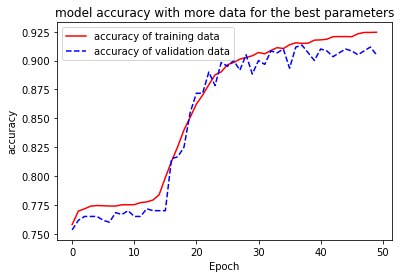

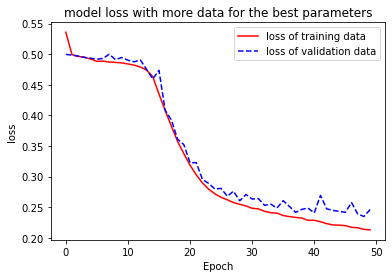

In [48]:
for obs in ('accuracy', 'loss'):
    plt.figure(figsize=(6,4))
    plt.plot(fit.history[obs],'r', label=obs+ ' of training data')
    #dashed line
    plt.plot(fit.history['val_'+obs], 'b--', label=obs+' of validation data')
    plt.ylabel(obs)
    plt.xlabel('Epoch')
    plt.title('model ' + obs + ' with more data for the best parameters')
    plt.legend()
    plt.savefig('model_bestparams.png')
    plt.show()

# <a name="4"> 4. Rescaling Data </a>

We rescale the data in order to see the differences with the previous case. 

In [49]:
x_train = x_train-0.5
x_test = x_test-0.5

In [50]:
from sklearn.model_selection import GridSearchCV
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier

# call Keras scikit wrapper
model_gridsearch = KerasClassifier(build_fn=compile_model, 
                        epochs=50, 
                        batch_size=50, 
                        verbose=1)

# list of allowed optional arguments for the optimizer, see compile_model()
optimizer = ['SGD', 'RMSprop', 'Adam', 'Adamax']
activation = ['sigmoid', 'relu', 'elu']
dropout_rate = [0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]
# define parameter dictionary
param_grid = dict(optimizer=optimizer, activation=activation, dropout_rate=dropout_rate)

# call scikit grid search module
grid = GridSearchCV(estimator=model_gridsearch, param_grid=param_grid, n_jobs=-1, cv=4)

# Loads grid_result from file if it exists
if os.path.isfile("HEAVY_grid_result_rescaled.pkl"):
    with open("HEAVY_grid_result_rescaled.pkl", "rb") as fid:
        grid_result = pickle.load(fid)
else:
    grid_result = grid.fit(x_train,y_train)
    with open("HEAVY_grid_result_rescaled.pkl", "wb") as fid:
        pickle.dump(grid_result, fid)

# summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

Best: 0.895755 using {'activation': 'sigmoid', 'dropout_rate': 0.0, 'optimizer': 'Adam'}
0.756667 (0.010992) with: {'activation': 'sigmoid', 'dropout_rate': 0.0, 'optimizer': 'SGD'}
0.889557 (0.017171) with: {'activation': 'sigmoid', 'dropout_rate': 0.0, 'optimizer': 'RMSprop'}
0.895755 (0.009398) with: {'activation': 'sigmoid', 'dropout_rate': 0.0, 'optimizer': 'Adam'}
0.892500 (0.007698) with: {'activation': 'sigmoid', 'dropout_rate': 0.0, 'optimizer': 'Adamax'}
0.756667 (0.010992) with: {'activation': 'sigmoid', 'dropout_rate': 0.1, 'optimizer': 'SGD'}
0.895182 (0.008114) with: {'activation': 'sigmoid', 'dropout_rate': 0.1, 'optimizer': 'RMSprop'}
0.891536 (0.009415) with: {'activation': 'sigmoid', 'dropout_rate': 0.1, 'optimizer': 'Adam'}
0.892292 (0.010545) with: {'activation': 'sigmoid', 'dropout_rate': 0.1, 'optimizer': 'Adamax'}
0.756667 (0.010992) with: {'activation': 'sigmoid', 'dropout_rate': 0.2, 'optimizer': 'SGD'}
0.895078 (0.012705) with: {'activation': 'sigmoid', 'dropo

In [51]:
best_activation ='sigmoid'
best_dropout = 0
best_optimizer = 'Adam'

In [52]:
model=compile_model(optimizer='Adam', activation="sigmoid",dropout_rate=0)

# Loads fit from file if it exists
# if os.path.isfile("HEAVY_fit_best.pkl"):
#     with open("HEAVY_fit_best.pkl", "rb") as fid:
#         fit = pickle.load(fid)
# else:
fit = model.fit(x_train, y_train, 
                epochs=70, batch_size = 50, 
                validation_data=(x_test, y_test),
                shuffle=True)
#     with open("HEAVY_fit_best.pkl", "wb") as fid:
#         pickle.dump(fit, fid)

Epoch 1/70
768/768 [==============================] - 3s 3ms/step - loss: 0.6291 - accuracy: 0.6691 - val_loss: 0.5129 - val_accuracy: 0.7600
Epoch 2/70
768/768 [==============================] - 1s 1ms/step - loss: 0.4961 - accuracy: 0.7711 - val_loss: 0.5020 - val_accuracy: 0.7617
Epoch 3/70
768/768 [==============================] - 1s 2ms/step - loss: 0.4982 - accuracy: 0.7744 - val_loss: 0.4998 - val_accuracy: 0.7650
Epoch 4/70
768/768 [==============================] - 1s 1ms/step - loss: 0.4912 - accuracy: 0.7745 - val_loss: 0.4959 - val_accuracy: 0.7633
Epoch 5/70
768/768 [==============================] - 1s 1ms/step - loss: 0.4920 - accuracy: 0.7749 - val_loss: 0.4950 - val_accuracy: 0.7667
Epoch 6/70
768/768 [==============================] - 1s 1ms/step - loss: 0.4886 - accuracy: 0.7755 - val_loss: 0.4921 - val_accuracy: 0.7617
Epoch 7/70
768/768 [==============================] - 1s 1ms/step - loss: 0.4847 - accuracy: 0.7808 - val_loss: 0.4879 - val_accuracy: 0.7700
Epoch 

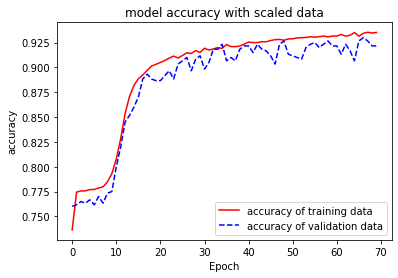

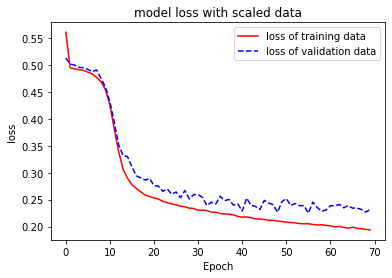

In [53]:
for obs in ('accuracy', 'loss'):
    plt.figure(figsize=(6,4))
    plt.plot(fit.history[obs],'r', label=obs+ ' of training data')
    #dashed line!!!
    plt.plot(fit.history['val_'+obs], 'b--', label=obs+' of validation data')
    plt.ylabel(obs)
    plt.xlabel('Epoch')
    plt.title('model ' + obs + ' with scaled data')
    plt.legend()
    plt.savefig('model_scaleddata.png')
    plt.show()

We get similiar result even if the validation loss seem to have smaller oscillation.

# <a name="change_variables">  Changing the number of hidden neurons  </a>

Using the rescaled data we investigate the effects of changing the number of hidden neurons.

In [54]:
def compile_model(neurons=L//2):
    # create the mode
    model=create_DNN(neurons=neurons)
    # compile the model
    model.compile(loss="binary_crossentropy",
                  optimizer='Adam',
                  metrics=['accuracy'])
    return model

def create_DNN(neurons):
    
    model=Sequential()
    model.add(Dense(L,input_shape=(L,), activation='sigmoid')) #add 1 layer
    model.add(Dense(neurons, activation='sigmoid')) #add 1 layer
    model.add(Dense(neurons, activation='sigmoid')) #add 1 layer
    model.add(Dropout(0.2)) #dropout
    model.add(Dense(1, activation="sigmoid"))
    
    return model
 
# call Keras scikit wrapper
model_gridsearch = KerasClassifier(build_fn=compile_model, 
                        epochs=60, 
                        batch_size=50, 
                        verbose=1)


neurons = [L//2, L//4, L//6, L//8, L//10]
# define parameter dictionary
param_grid = dict(neurons=neurons)
grid = GridSearchCV(estimator=model_gridsearch, param_grid=param_grid, n_jobs=-1, cv=4)

# Loads grid_result from file if it exists
if os.path.isfile("HEAVY_grid_result_neurons.pkl"):
    with open("HEAVY_grid_result_neurons.pkl", "rb") as fid:
        grid_result = pickle.load(fid)
else:
    grid_result = grid.fit(x_train,y_train)
    with open("HEAVY_grid_result_neurons.pkl", "wb") as fid:
        pickle.dump(grid_result, fid)

print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))


Best: 0.899557 using {'neurons': 32}
0.899557 (0.009461) with: {'neurons': 32}
0.896458 (0.007247) with: {'neurons': 16}
0.891536 (0.013180) with: {'neurons': 10}
0.894427 (0.011445) with: {'neurons': 8}
0.892083 (0.007613) with: {'neurons': 6}


In [55]:
model=compile_model(neurons=32)   

fit_neurons = model.fit(x_train, y_train, 
               epochs=60, batch_size = 50, 
               validation_data=(x_test, y_test),
               shuffle=True)

Epoch 1/60
768/768 [==============================] - 2s 2ms/step - loss: 0.5939 - accuracy: 0.7050 - val_loss: 0.4996 - val_accuracy: 0.7567
Epoch 2/60
768/768 [==============================] - 2s 3ms/step - loss: 0.4973 - accuracy: 0.7690 - val_loss: 0.5003 - val_accuracy: 0.7583
Epoch 3/60
768/768 [==============================] - 2s 2ms/step - loss: 0.5012 - accuracy: 0.7703 - val_loss: 0.4998 - val_accuracy: 0.7667
Epoch 4/60
768/768 [==============================] - 1s 2ms/step - loss: 0.4936 - accuracy: 0.7721 - val_loss: 0.4941 - val_accuracy: 0.7617
Epoch 5/60
768/768 [==============================] - 1s 1ms/step - loss: 0.4932 - accuracy: 0.7725 - val_loss: 0.4928 - val_accuracy: 0.7617
Epoch 6/60
768/768 [==============================] - 1s 2ms/step - loss: 0.4887 - accuracy: 0.7735 - val_loss: 0.4908 - val_accuracy: 0.7600
Epoch 7/60
768/768 [==============================] - 1s 1ms/step - loss: 0.4876 - accuracy: 0.7766 - val_loss: 0.4900 - val_accuracy: 0.7617
Epoch 

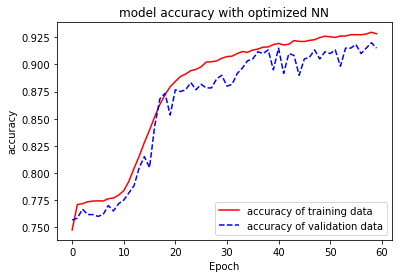

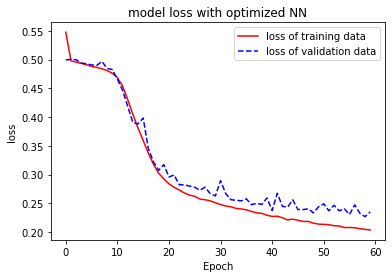

In [56]:
for obs in ('accuracy', 'loss'):
    plt.figure(figsize=(6,4))
    plt.plot(fit_neurons.history[obs],'r', label=obs+ ' of training data')
    #dashed line!!!
    plt.plot(fit_neurons.history['val_'+obs], 'b--', label=obs+' of validation data')
    plt.ylabel(obs)
    plt.xlabel('Epoch')
    plt.legend()
    plt.title('model ' + obs + ' with optimized NN')
    plt.savefig('model_neur.png')
    plt.show()